In [4]:
import sys
sys.path.append('../scripts/')
from mcl import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [5]:
def sigma_ellipse(p, cov, n):
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=2*n*math.sqrt(eig_vals[0]),height=2*n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

def matM(nu, omega, time, stds):
    return np.diag([stds["nn"]**2*abs(nu)/time + stds["no"]**2*abs(omega)/time, 
                               stds["on"]**2*abs(nu)/time + stds["oo"]**2*abs(omega)/time])
    
def matA(nu, omega, time, theta):
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*time), math.cos(theta + omega*time)
    return np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )

def matF(nu, omega, time, theta):
    F = np.diag([1.0, 1.0, 1.0])
    F[0, 2] = nu / omega * (math.cos(theta + omega * time) - math.cos(theta))
    F[1, 2] = nu / omega * (math.sin(theta + omega * time) - math.sin(theta))
    return F

def matH(pose, landmark_pos): ###kf4funcs
    mx, my = landmark_pos
    mux, muy, mut = pose
    q = (mux - mx)**2 + (muy - my)**2
    return np.array([[(mux - mx)/np.sqrt(q), (muy - my)/np.sqrt(q), 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])

def matQ(distance_dev, direction_dev):
    return np.diag(np.array([distance_dev**2, direction_dev**2]))

In [7]:
class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=init_pose, cov=np.diag([1e-10, 1e-10, 1e-10])) 
        self.pose = self.belief.mean
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap  #以下3行追加（Mclと同じ）
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):  #追加
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            H = matH(self.belief.mean, self.map.landmarks[obs_id].pos)
            estimated_z = IdealCamera.observation_function(self.belief.mean, self.map.landmarks[obs_id].pos)
            Q = matQ(estimated_z[0]*self.distance_dev_rate, self.direction_dev)
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            self.belief.mean += K.dot(z - estimated_z)
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
            self.pose = self.belief.mean
        
    def motion_update(self, nu, omega, time): #追加
        if abs(omega) < 1e-5: omega = 1e-5 #値が0になるとゼロ割りになって計算ができないのでわずかに値を持たせる

        M = matM(nu, omega, time, self.motion_noise_stds)
        A = matA(nu, omega, time, self.belief.mean[2])
        F = matF(nu, omega, time, self.belief.mean[2])
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        self.pose = self.belief.mean #他のクラスで使う
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

<IPython.core.display.Javascript object>


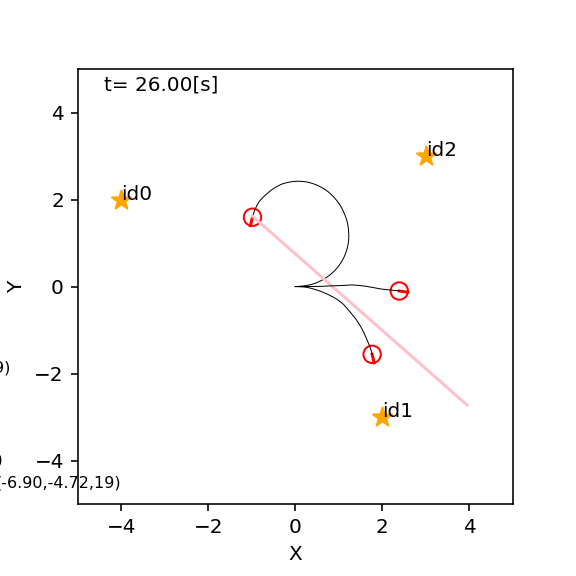

In [8]:
if __name__ == '__main__':
    time_interval = 0.1
    world = World(30,time_interval,debug = False)
    
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0,0,0]).T
    kf = KalmanFilter(m, initial_pose)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,kf)
    r = Robot(initial_pose, sensor = Camera(m), agent = circling, color = "red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    linear = EstimationAgent(time_interval, 0.1, 0.0, kf)
    r = Robot(initial_pose, sensor = Camera(m), agent = linear, color = "red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    right = EstimationAgent(time_interval, 0.1, -3.0 / 180 * math.pi, kf)
    r = Robot(initial_pose, sensor = Camera(m), agent = right, color = "red")
    world.append(r)
    world.draw()

# 各ロボットの分布が楕円で表現
